In [19]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st
from sklearn.decomposition import PCA

# Dataset: FRED-MD

In [20]:
# macroeconomic database of monthly U.S. indicators 
# such as output and income, the labor market and prices from 1959 to 2020
df = pd.read_csv(r"current.csv")
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2437.296,2288.8,17.302,2.922588e+05,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2446.902,2297.0,17.482,2.944295e+05,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2462.689,2314.0,17.647,2.934254e+05,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2478.744,2330.3,17.584,2.993317e+05,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,6/1/2020,17990.747,13521.2,114.880,1.515750e+06,529962.00000,97.6071,93.9394,93.0396,98.6589,...,119.838,25.38,29.32,22.61,78.1,20979.3,334036.91,719924.00,4170.7929,30.0744
739,7/1/2020,18110.849,13713.8,116.322,1.549057e+06,535923.00000,101.6989,98.0911,97.7693,103.5054,...,120.048,25.44,29.30,22.81,72.5,21079.5,338930.02,725019.07,4290.0949,24.3785
740,8/1/2020,17609.010,13875.6,117.152,1.550404e+06,538979.00000,102.1509,99.0661,98.6480,104.2163,...,120.360,25.47,29.40,22.81,74.1,21114.7,341624.48,727855.23,4344.8069,20.2777
741,9/1/2020,17733.106,14010.5,118.599,NaN,549256.00000,101.5055,97.9490,97.3806,102.5015,...,120.741,25.42,29.07,22.94,80.4,21284.1,NaN,NaN,4396.7473,28.3241


In [21]:
# drop any column that has a nan value
# fred = df[252:-2].dropna()
fred = df[1:].dropna()

# transform it into an numpy ndarray, and set aside the dates
fred = fred.to_numpy().T
months = fred[0]
fred = np.delete(fred, 0, 0)
fred

array([[7968.831, 7982.053000000001, 8011.806, ..., 18296.406000000003,
        17990.747, 18110.849],
       [6879.1, 6884.7, 6903.6, ..., 13333.2, 13521.2, 13713.8],
       [55.965, 56.067, 56.114, ..., 108.449, 114.88, 116.322],
       ...,
       [189752.08, 190887.95, 190911.8, ..., 718836.96, 719924.0,
        725019.07],
       [744.2592, 749.7716, 755.9008, ..., 4031.3344, 4170.7929,
        4290.0949],
       [17.0505, 16.2227, 16.1885, ..., 30.4751, 30.0744, 24.3785]],
      dtype=object)

In [85]:
# difference the non-stationary series to stationarity
# check for non-stationary and take differences of non-stationary series
def non_stationary(timeseries):
    # Perform augmented Dickey-Fuller test and return whether the test statistic is greater than the critical value,
    # which means the time series is non-stationary. We pick an alpha = 0.10
    dftest = st.adfuller(timeseries, autolag='AIC')
    test_statistic = dftest[0]
    crit_value = dftest[4]['10%']
    return test_statistic > crit_value

stationary_fred = fred.copy()
# print(len(stationary_fred))
# print(len(stationary_fred[0]))
for i in range(len(stationary_fred)):
    if non_stationary(stationary_fred[i]):
        diffs = []
        for j in range(1, len(stationary_fred[i])):
            diffs.append(stationary_fred[i][j] - stationary_fred[i][j-1])
        diffs.insert(0, np.mean(diffs))
        stationary_fred[i] = diffs

# print(stationary_fred.shape)

In [23]:
# standardize the series to have zero mean and unit variance before extracting principal components
def center(series):
    zero_mean = series - np.mean(series)
    unit_variance = zero_mean / (np.std(series))
    return unit_variance

In [24]:
# standardize all columns to have zero mean and unit variance
whitened_fred = np.empty(shape=(0,0))
for col in stationary_fred:
    # don't apply this to malformed columns, i.e. columns with nan or non-floats
    if not isinstance(col[0], str):
        whitened_fred = np.append(whitened_fred, center(col))
whitened_fred = whitened_fred.reshape((128, 341))


In [25]:
# test 
# for col in whitened_fred:
#     print(np.mean(col), "\t", np.std(col))

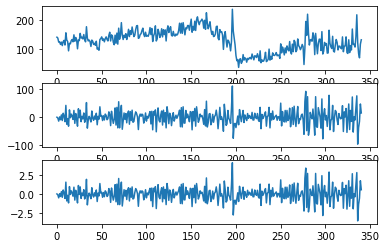

In [26]:
def plotter(index):
    fig, axs = plt.subplots(3)
    fig.figsize = [6.4, 9.6]
    axs[0].plot(fred[index])
    axs[1].plot(stationary_fred[index])
    axs[2].plot(whitened_fred[index])
plotter(48)

In [27]:
feat_cols = ['feature'+str(i) for i in range(whitened_fred.shape[1])]
normalized_fred = pd.DataFrame(whitened_fred,columns=feat_cols)
normalized_fred.tail()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340
123,4.49324e-17,-0.185234,-0.232029,-0.192822,-0.254794,-0.214323,-0.170689,-0.187763,-0.225073,-0.240882,...,0.459782,0.772172,0.569181,0.129053,0.461679,0.0771991,4.71815,17.0993,1.23886,0.289675
124,0,-0.40093,0.102143,-0.612638,0.000122768,-0.0454562,-0.130651,-0.249284,-0.238208,-0.316587,...,-0.154859,-0.0212269,-0.181169,0.229758,-0.287014,-0.553954,-0.231071,1.38576,1.49995,0.869981
125,0,-0.0305643,-0.108084,-0.105331,0.0125483,-0.101678,0.0557321,-0.0433068,-0.144828,0.020823,...,-0.259774,-0.0506801,-0.111914,-0.0775822,-0.229771,-0.393906,-0.520765,-0.0105901,-0.0339683,0.245435
126,8.88183e-17,-0.245828,-0.214988,-0.0357616,-0.0791618,0.0285487,0.0563039,-0.262388,-0.223223,-0.0934019,...,2.61688,0.135179,1.52412,-0.60306,0.0445238,1.1987,5.49297,1.26316,6.45151,5.44368
127,-0.287657,-0.381626,-0.385509,-0.5513,-0.548451,-0.712994,-0.586002,-0.604596,-0.239061,-0.566511,...,-0.371932,-0.408462,-0.788062,-0.708078,-0.6247,0.0900478,5.02828,1.23626,1.19078,0.544195


This is the normalized aggregate data we will use to test for time-varying loadings.

In [80]:
# First 10 principle components of the aggregate macro data
N = 10
pca_fred = PCA(n_components = N)
principalComponents_fred = pca_fred.fit_transform(normalized_fred)
principalComponents_fred

array([[13.39542229, -0.16982711,  2.78258618, ..., -0.14497251,
         2.92290535,  1.43707741],
       [-5.95500128, -4.72313826,  3.32649165, ..., -1.99094571,
         3.35026466,  0.16482184],
       [-9.02076883, -1.68618171, -0.31984686, ..., -1.38034259,
        -0.76744841, -0.55761462],
       ...,
       [ 2.43056938,  1.36944082,  1.98185077, ...,  0.85974254,
        -5.15869888, -2.10355711],
       [ 4.47775131, -1.72397494,  1.23648371, ...,  1.21930465,
        -2.65883725, -4.55096615],
       [ 8.97761237, -5.71247717,  0.81911256, ..., -1.43947057,
         2.47033677,  0.15374788]])

In [81]:
principal_fred_df = pd.DataFrame(data = principalComponents_fred
             , columns = ['PC'+str(i) for i in range(1, N+1)])
principal_fred_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,13.395422,-0.169827,2.782586,2.298979,7.425322,0.181763,1.342998,-0.144973,2.922905,1.437077
1,-5.955001,-4.723138,3.326492,0.111672,4.396897,0.199154,0.551406,-1.990946,3.350265,0.164822
2,-9.020769,-1.686182,-0.319847,-1.625403,7.084276,-3.645539,1.572542,-1.380343,-0.767448,-0.557615
3,-6.929650,-2.287670,-0.160429,-2.959228,8.403838,-0.397875,0.445318,-0.602390,-1.017346,-1.063793
4,-2.182472,5.245021,-2.489559,-0.742918,9.093840,-2.099706,0.897918,-1.655992,-2.565303,-0.489652
...,...,...,...,...,...,...,...,...,...,...
123,19.910437,2.420427,2.325542,-2.120505,1.967976,1.540513,-1.444273,2.055297,-1.604109,-1.487860
124,3.545385,0.498900,0.251806,-1.955564,0.975539,2.153239,9.609546,-0.117893,-5.299369,-2.465072
125,2.430569,1.369441,1.981851,-0.942428,-0.867867,3.655868,10.873718,0.859743,-5.158699,-2.103557
126,4.477751,-1.723975,1.236484,-6.359919,-0.464933,-1.772652,-7.569364,1.219305,-2.658837,-4.550966


In [82]:
fred_explained_variance = pca_fred.explained_variance_ratio_
fred_explained_variance_df = pd.DataFrame(fred_explained_variance, columns = ['Explained Variance'])
fred_explained_variance_df.rename(index = lambda x: 'PC'+str(x+1), inplace=True)
fred_explained_variance_df

,Explained Variance
PC1,0.222928
PC2,0.088753
PC3,0.079508
PC4,0.055975
PC5,0.043919
PC6,0.032768
PC7,0.028641
PC8,0.025404
PC9,0.024870
PC10,0.023813


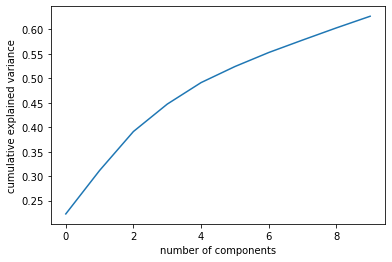

In [83]:
plt.plot(np.cumsum(fred_explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');